# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    
    image_path = './' + data_dir
    
    p_dataset = datasets.ImageFolder(image_path, transform)
    
    return DataLoader(dataset=p_dataset, batch_size=batch_size, shuffle=True)

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

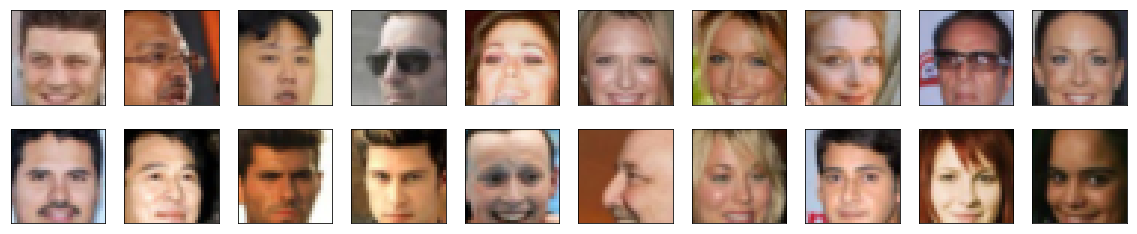

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    min, max = feature_range
    x = x * (max - min) + min
    
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8275)
Max:  tensor(0.8667)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# helper conv function
# from the cycleGAN exercise notebook
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        #convolutionallayers
        # in 32 x 32 x 3
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        # in 16 x 16 x conv_dim
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)
        # in 8 x 8 x conv_dim * 2
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4)
        
        # in 4 x 4 x conv_dim * 4
        self.fc = nn.Linear(conv_dim * 4 * 4 * 4, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.1)
        x = F.leaky_relu(self.conv2(x), 0.1)
        x = F.leaky_relu(self.conv3(x), 0.1)
        
        # flatten
        x = x.view(-1, self.conv_dim * 4 * 4 * 4)
        
        # fc layer
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
# helper deconv function
# from cycleGAN exercise
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim * 4 * 4 * 4)
        
        self.t_conv1 = deconv (conv_dim * 4, conv_dim * 2, 4)
        self.t_conv2 = deconv (conv_dim * 2, conv_dim, 4)
        self.t_conv3 = deconv (conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        #reshape correctly
        x = x.view(-1, self.conv_dim * 4, 4, 4)

        x = F.relu(self.t_conv1(x)) 
        x = F.relu(self.t_conv2(x))
        x = F.tanh(self.t_conv3(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
        # check if bias terms exist and set them to 0
        if hasattr(m.bias, 'data'):
            nn.init.constant_(m.bias.data, 0.0)
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [17]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=8192, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1,

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [20]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    batch_size = D_out.size(0)
    
    # create labels of 1 (real)
    labels = torch.ones(batch_size)
        
    if train_on_gpu:
        labels = labels.cuda()
    
    # use binary cross entropy loss
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    
    # create labels of 0 (fake)
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
        
    # use binary cross entropy loss
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels) 
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [21]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2)) 

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [22]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            d_optimizer.zero_grad()
            
            # 1. Train the discriminator on real and fake images
            # code is slightly edited from the DCGAN exercise
            # Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()
        
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
        
            # Train with fake images
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
        
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step() 

            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            # Train with fake images and flipped labels
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
        
            # perform backprop
            g_loss.backward()
            g_optimizer.step() 
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [23]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.6165 | g_loss: 1.2383
Epoch [    1/   50] | d_loss: 0.0616 | g_loss: 5.3523
Epoch [    1/   50] | d_loss: 0.3049 | g_loss: 4.3398
Epoch [    1/   50] | d_loss: 0.6186 | g_loss: 4.2370
Epoch [    1/   50] | d_loss: 0.5614 | g_loss: 1.7407
Epoch [    1/   50] | d_loss: 0.8031 | g_loss: 4.0758
Epoch [    1/   50] | d_loss: 0.6329 | g_loss: 1.6378
Epoch [    1/   50] | d_loss: 0.8571 | g_loss: 2.2193
Epoch [    1/   50] | d_loss: 0.6623 | g_loss: 2.3923
Epoch [    1/   50] | d_loss: 1.2352 | g_loss: 3.5623
Epoch [    1/   50] | d_loss: 0.6201 | g_loss: 2.2909
Epoch [    1/   50] | d_loss: 0.9818 | g_loss: 0.9643
Epoch [    1/   50] | d_loss: 0.6533 | g_loss: 1.6887
Epoch [    1/   50] | d_loss: 0.6948 | g_loss: 2.4428
Epoch [    1/   50] | d_loss: 0.8410 | g_loss: 1.9675
Epoch [    1/   50] | d_loss: 0.9971 | g_loss: 2.2790
Epoch [    1/   50] | d_loss: 0.6966 | g_loss: 1.1938
Epoch [    1/   50] | d_loss: 0.9229 | g_loss: 1.9045
Epoch [    1/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.8586 | g_loss: 1.1510
Epoch [    6/   50] | d_loss: 0.7657 | g_loss: 1.5267
Epoch [    6/   50] | d_loss: 2.5106 | g_loss: 4.0417
Epoch [    6/   50] | d_loss: 0.6171 | g_loss: 1.8869
Epoch [    6/   50] | d_loss: 0.6289 | g_loss: 1.6130
Epoch [    6/   50] | d_loss: 0.6411 | g_loss: 1.4974
Epoch [    6/   50] | d_loss: 0.8289 | g_loss: 1.3354
Epoch [    6/   50] | d_loss: 1.2218 | g_loss: 1.0757
Epoch [    6/   50] | d_loss: 1.4812 | g_loss: 0.6432
Epoch [    6/   50] | d_loss: 0.7467 | g_loss: 1.1986
Epoch [    6/   50] | d_loss: 0.6913 | g_loss: 1.2039
Epoch [    6/   50] | d_loss: 0.9751 | g_loss: 0.9164
Epoch [    6/   50] | d_loss: 0.6403 | g_loss: 1.0383
Epoch [    6/   50] | d_loss: 1.2834 | g_loss: 2.5885
Epoch [    6/   50] | d_loss: 0.8722 | g_loss: 1.1616
Epoch [    6/   50] | d_loss: 1.2694 | g_loss: 3.4445
Epoch [    6/   50] | d_loss: 0.9419 | g_loss: 3.1513
Epoch [    6/   50] | d_loss: 0.9124 | g_loss: 2.3966
Epoch [    6/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.6046 | g_loss: 2.1664
Epoch [   11/   50] | d_loss: 0.4045 | g_loss: 2.0095
Epoch [   11/   50] | d_loss: 0.2002 | g_loss: 4.0986
Epoch [   11/   50] | d_loss: 0.6761 | g_loss: 1.6634
Epoch [   11/   50] | d_loss: 0.3550 | g_loss: 2.0806
Epoch [   11/   50] | d_loss: 0.4901 | g_loss: 3.2146
Epoch [   11/   50] | d_loss: 0.3589 | g_loss: 3.8187
Epoch [   11/   50] | d_loss: 0.5490 | g_loss: 2.0862
Epoch [   11/   50] | d_loss: 0.3766 | g_loss: 3.0588
Epoch [   11/   50] | d_loss: 0.7783 | g_loss: 2.9841
Epoch [   11/   50] | d_loss: 0.4201 | g_loss: 2.3560
Epoch [   11/   50] | d_loss: 0.3714 | g_loss: 3.4514
Epoch [   11/   50] | d_loss: 0.8276 | g_loss: 3.2247
Epoch [   11/   50] | d_loss: 0.3582 | g_loss: 3.3319
Epoch [   11/   50] | d_loss: 0.3200 | g_loss: 2.9410
Epoch [   12/   50] | d_loss: 0.4915 | g_loss: 1.6993
Epoch [   12/   50] | d_loss: 0.4177 | g_loss: 2.4504
Epoch [   12/   50] | d_loss: 0.2435 | g_loss: 3.0951
Epoch [   12/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.1625 | g_loss: 3.3350
Epoch [   16/   50] | d_loss: 0.8614 | g_loss: 5.1445
Epoch [   16/   50] | d_loss: 0.2258 | g_loss: 2.3392
Epoch [   16/   50] | d_loss: 0.2326 | g_loss: 3.4511
Epoch [   16/   50] | d_loss: 0.5002 | g_loss: 1.6266
Epoch [   16/   50] | d_loss: 0.9949 | g_loss: 2.3923
Epoch [   16/   50] | d_loss: 0.1749 | g_loss: 3.6489
Epoch [   16/   50] | d_loss: 0.3104 | g_loss: 3.1317
Epoch [   17/   50] | d_loss: 0.2121 | g_loss: 3.2932
Epoch [   17/   50] | d_loss: 0.2210 | g_loss: 2.9419
Epoch [   17/   50] | d_loss: 0.1829 | g_loss: 3.7646
Epoch [   17/   50] | d_loss: 0.1273 | g_loss: 3.6251
Epoch [   17/   50] | d_loss: 0.1639 | g_loss: 3.7048
Epoch [   17/   50] | d_loss: 0.3417 | g_loss: 3.4511
Epoch [   17/   50] | d_loss: 0.3351 | g_loss: 6.4275
Epoch [   17/   50] | d_loss: 0.2070 | g_loss: 3.8431
Epoch [   17/   50] | d_loss: 0.2941 | g_loss: 4.0518
Epoch [   17/   50] | d_loss: 0.6434 | g_loss: 2.6791
Epoch [   17/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.1283 | g_loss: 2.6249
Epoch [   22/   50] | d_loss: 0.5512 | g_loss: 7.3225
Epoch [   22/   50] | d_loss: 0.0480 | g_loss: 5.1950
Epoch [   22/   50] | d_loss: 0.4394 | g_loss: 3.9547
Epoch [   22/   50] | d_loss: 0.2145 | g_loss: 4.7808
Epoch [   22/   50] | d_loss: 0.1599 | g_loss: 4.9187
Epoch [   22/   50] | d_loss: 0.1019 | g_loss: 3.3070
Epoch [   22/   50] | d_loss: 0.2143 | g_loss: 5.1782
Epoch [   22/   50] | d_loss: 0.1550 | g_loss: 4.3993
Epoch [   22/   50] | d_loss: 0.1428 | g_loss: 5.2761
Epoch [   22/   50] | d_loss: 0.1131 | g_loss: 4.8450
Epoch [   22/   50] | d_loss: 0.0313 | g_loss: 4.8392
Epoch [   22/   50] | d_loss: 1.6992 | g_loss: 6.4771
Epoch [   22/   50] | d_loss: 0.2108 | g_loss: 3.3086
Epoch [   22/   50] | d_loss: 0.1861 | g_loss: 3.4943
Epoch [   22/   50] | d_loss: 0.2141 | g_loss: 5.0342
Epoch [   22/   50] | d_loss: 0.1437 | g_loss: 3.9259
Epoch [   22/   50] | d_loss: 0.0988 | g_loss: 3.4942
Epoch [   22/   50] | d_loss

Epoch [   27/   50] | d_loss: 1.0325 | g_loss: 0.9250
Epoch [   27/   50] | d_loss: 0.1870 | g_loss: 4.5565
Epoch [   27/   50] | d_loss: 0.0680 | g_loss: 4.7467
Epoch [   27/   50] | d_loss: 0.1380 | g_loss: 4.4462
Epoch [   27/   50] | d_loss: 0.0984 | g_loss: 4.4905
Epoch [   27/   50] | d_loss: 0.1001 | g_loss: 4.1706
Epoch [   27/   50] | d_loss: 0.4502 | g_loss: 1.5622
Epoch [   27/   50] | d_loss: 0.1619 | g_loss: 4.7532
Epoch [   27/   50] | d_loss: 0.1200 | g_loss: 4.9047
Epoch [   27/   50] | d_loss: 0.0905 | g_loss: 4.9292
Epoch [   27/   50] | d_loss: 0.1023 | g_loss: 4.7693
Epoch [   27/   50] | d_loss: 0.1870 | g_loss: 3.8761
Epoch [   27/   50] | d_loss: 0.0343 | g_loss: 6.1464
Epoch [   27/   50] | d_loss: 0.0577 | g_loss: 6.2075
Epoch [   27/   50] | d_loss: 0.2490 | g_loss: 4.9298
Epoch [   27/   50] | d_loss: 0.0225 | g_loss: 5.4660
Epoch [   27/   50] | d_loss: 0.4518 | g_loss: 2.5225
Epoch [   27/   50] | d_loss: 0.1222 | g_loss: 5.6481
Epoch [   27/   50] | d_loss

Epoch [   32/   50] | d_loss: 0.0394 | g_loss: 5.7271
Epoch [   32/   50] | d_loss: 0.0675 | g_loss: 5.5573
Epoch [   32/   50] | d_loss: 0.0622 | g_loss: 6.9309
Epoch [   32/   50] | d_loss: 0.0343 | g_loss: 5.0806
Epoch [   32/   50] | d_loss: 0.0351 | g_loss: 4.2079
Epoch [   32/   50] | d_loss: 1.7037 | g_loss: 4.1641
Epoch [   32/   50] | d_loss: 0.1986 | g_loss: 3.6981
Epoch [   32/   50] | d_loss: 0.4234 | g_loss: 2.5965
Epoch [   32/   50] | d_loss: 0.1244 | g_loss: 2.9579
Epoch [   32/   50] | d_loss: 0.2258 | g_loss: 4.4578
Epoch [   32/   50] | d_loss: 0.2361 | g_loss: 5.1693
Epoch [   32/   50] | d_loss: 0.2163 | g_loss: 4.9935
Epoch [   32/   50] | d_loss: 0.0439 | g_loss: 5.2030
Epoch [   32/   50] | d_loss: 0.0712 | g_loss: 5.4561
Epoch [   32/   50] | d_loss: 0.1564 | g_loss: 6.6182
Epoch [   32/   50] | d_loss: 0.1384 | g_loss: 4.4196
Epoch [   33/   50] | d_loss: 0.0642 | g_loss: 3.2077
Epoch [   33/   50] | d_loss: 0.0505 | g_loss: 5.3559
Epoch [   33/   50] | d_loss

Epoch [   37/   50] | d_loss: 0.0163 | g_loss: 5.0971
Epoch [   37/   50] | d_loss: 0.0803 | g_loss: 4.1615
Epoch [   37/   50] | d_loss: 0.0634 | g_loss: 4.5512
Epoch [   37/   50] | d_loss: 0.0187 | g_loss: 5.8741
Epoch [   37/   50] | d_loss: 0.0126 | g_loss: 5.7396
Epoch [   37/   50] | d_loss: 0.1164 | g_loss: 6.7368
Epoch [   37/   50] | d_loss: 0.0551 | g_loss: 5.1970
Epoch [   37/   50] | d_loss: 0.0396 | g_loss: 7.5506
Epoch [   37/   50] | d_loss: 0.1864 | g_loss: 4.6261
Epoch [   38/   50] | d_loss: 0.7495 | g_loss: 2.4846
Epoch [   38/   50] | d_loss: 1.7919 | g_loss: 9.1046
Epoch [   38/   50] | d_loss: 0.4294 | g_loss: 3.9542
Epoch [   38/   50] | d_loss: 0.0939 | g_loss: 4.2737
Epoch [   38/   50] | d_loss: 0.1456 | g_loss: 3.7902
Epoch [   38/   50] | d_loss: 0.1062 | g_loss: 3.4668
Epoch [   38/   50] | d_loss: 0.0517 | g_loss: 6.2320
Epoch [   38/   50] | d_loss: 0.0863 | g_loss: 4.5554
Epoch [   38/   50] | d_loss: 0.0790 | g_loss: 6.2611
Epoch [   38/   50] | d_loss

Epoch [   42/   50] | d_loss: 0.1654 | g_loss: 4.7278
Epoch [   42/   50] | d_loss: 0.1090 | g_loss: 5.5497
Epoch [   43/   50] | d_loss: 0.0498 | g_loss: 5.3932
Epoch [   43/   50] | d_loss: 0.0722 | g_loss: 4.8943
Epoch [   43/   50] | d_loss: 0.0195 | g_loss: 6.7299
Epoch [   43/   50] | d_loss: 0.0283 | g_loss: 5.6755
Epoch [   43/   50] | d_loss: 0.0210 | g_loss: 4.7718
Epoch [   43/   50] | d_loss: 0.0347 | g_loss: 4.9229
Epoch [   43/   50] | d_loss: 0.7399 | g_loss: 4.6446
Epoch [   43/   50] | d_loss: 0.2286 | g_loss: 4.0298
Epoch [   43/   50] | d_loss: 0.2184 | g_loss: 2.2299
Epoch [   43/   50] | d_loss: 0.0776 | g_loss: 5.1121
Epoch [   43/   50] | d_loss: 0.0436 | g_loss: 5.4618
Epoch [   43/   50] | d_loss: 0.0308 | g_loss: 5.2315
Epoch [   43/   50] | d_loss: 0.0211 | g_loss: 6.9620
Epoch [   43/   50] | d_loss: 0.0826 | g_loss: 5.5076
Epoch [   43/   50] | d_loss: 0.0589 | g_loss: 5.7948
Epoch [   43/   50] | d_loss: 0.0580 | g_loss: 6.8834
Epoch [   43/   50] | d_loss

Epoch [   48/   50] | d_loss: 0.0473 | g_loss: 4.9576
Epoch [   48/   50] | d_loss: 0.0998 | g_loss: 5.2571
Epoch [   48/   50] | d_loss: 0.0430 | g_loss: 5.8492
Epoch [   48/   50] | d_loss: 0.0323 | g_loss: 4.7073
Epoch [   48/   50] | d_loss: 0.0248 | g_loss: 7.0320
Epoch [   48/   50] | d_loss: 0.0813 | g_loss: 6.7967
Epoch [   48/   50] | d_loss: 0.1314 | g_loss: 4.9664
Epoch [   48/   50] | d_loss: 0.1126 | g_loss: 7.0947
Epoch [   48/   50] | d_loss: 0.3159 | g_loss: 2.2903
Epoch [   48/   50] | d_loss: 0.0929 | g_loss: 4.7724
Epoch [   48/   50] | d_loss: 0.0265 | g_loss: 6.0672
Epoch [   48/   50] | d_loss: 0.0206 | g_loss: 6.1993
Epoch [   48/   50] | d_loss: 0.1546 | g_loss: 6.4276
Epoch [   48/   50] | d_loss: 0.2275 | g_loss: 4.1155
Epoch [   48/   50] | d_loss: 1.4671 | g_loss: 2.3549
Epoch [   48/   50] | d_loss: 0.0973 | g_loss: 5.5821
Epoch [   48/   50] | d_loss: 0.0487 | g_loss: 5.2113
Epoch [   48/   50] | d_loss: 0.0166 | g_loss: 6.1074
Epoch [   48/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

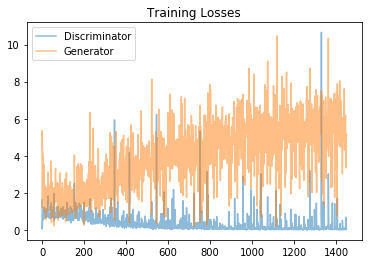

In [25]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [26]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [27]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

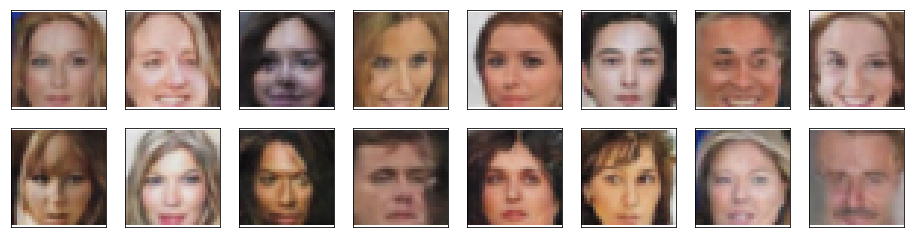

In [28]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

* The model is generating very low quality images that are small in size. Therefore I would like to try making a deeper model which can output a larger image, then I would like to figure out how to increase the resolution of the generated images.
* A more diverse dataset would work better as the network will be able to train on a more general dataset and create images with more variance (skin tone, age, gender).
* I would like to decrease the learning rate and increase the number of epochs as well, whilst using a deeper model. I believe this would increase clarity and accuracy, also if you look at image 16 (bottom right) above there is some issues which I believe a deeper model would fix. A staggered learning rate might also work, similar to the one I used for the dog classifier (trained a lr for 50 epochs, then at lr<sup>-1</sup> for a further 30 epochs).
* When creating the deeper model it would need to be trained on larger images (128 x 128 or even 256 x 256), I think the addition of Residual blocks (as in the CycleGAN exercise) would help to make this model better when training on the larger images.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.